## 内容过滤及分类——基于物品属性的过滤
基于协同过滤（也称为社会过滤，social filtering）的推荐。 在协同过滤中，我们利用了用户社区的力量来帮助进行推荐。你购买了Wolfgang Amadeus Phoenix，而我们知道购买该专辑的很多顾客同时也购买了Vampire Weekend的“Contra”，因此我们将后者推荐给你。

协同过滤中的难点，包括数据稀疏和扩展性带来的问题。另一个问题是基于协同过滤的推荐系统倾向于推荐已流行的物品，即偏向于流行事物。作为一个极端的例子，考虑一个全新乐队刚发布的专辑，由于乐队和专辑从没被人评过分，因此它永远不会被推荐（这是推荐系统中所谓的“冷启动”问题）。

针对协同过滤的问题，我们采用基于物品属性的过滤算法。

### 选择合适取值的重要性
Pandora的推荐基于一种称为音乐基因的项目（The Music Genome Project）。他们雇了一些具有很强音乐理论背景的专业音乐人士作为分析师，由他们来决定歌曲的特征（他们称之为基因）。这些分析师会接受超过150个小时的培训。一旦培训完毕，他们就会花平均20～30分钟的时间来分析一首歌曲以确定其基因或者说特征。这些特征当中很多都是专业性的。分析师会在超过400种基因上进行评分。由于每个月都大约添加15000首新歌，因此上 述做法的工作量很大。

假设Pandora使用的两个基因：流派（genre）和情绪（mood）。这些基因的值如下所示：
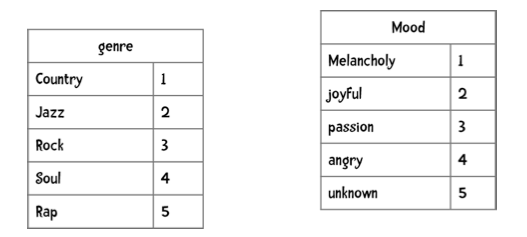

因此，如果流派的取值为4，则表示“灵魂乐”，而如果情绪音乐的取值为3则表示“激动”。假设有一首忧郁的摇滚歌曲，比如James Blunt的那首令人窒息的 You’re Beautiful。 从二维空间来看，可以在纸上画出这首歌曲，如下：
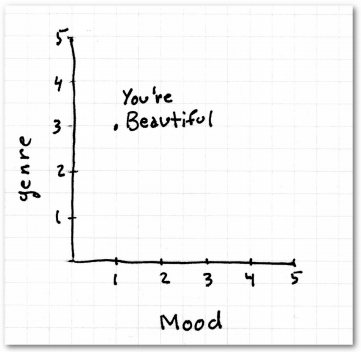

比如一个叫Tex的用户喜欢You're Beautiful这首歌，我们想要为他推荐歌曲。我们的歌曲库中有另外三首歌：歌曲1是悲伤的爵士乐；歌曲2是愤怒的圣歌；歌曲3是愤怒的摇滚乐。你会推荐哪一首？
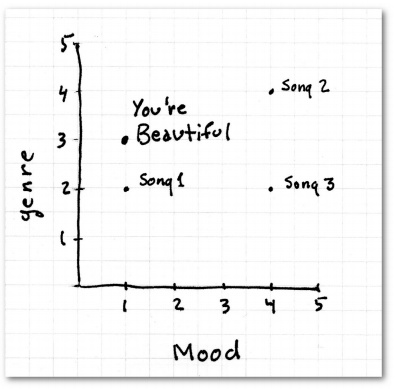

图中歌曲1看起来是最相近的。也许你已经看出了这种算法中的不足，因为不管用何种计算距离的公式，爵士乐和摇滚乐是相近的，悲伤的乐曲和快乐的乐曲是相近的等等。即使调整了分值的分配，也不能解决问题。这就是没有选取好特征值的例子。不过解决的方法也很简单，我们将每种歌曲类型拆分成单独的特征，并对此进行打分：
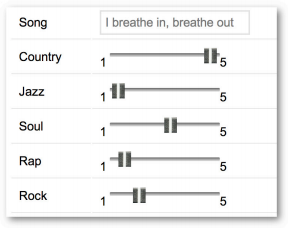

“乡村音乐”一栏的1分表示完全不是这个乐曲风格，5分则表示很相符。这样一来，评分值就显得有意义了。如果一首歌的“乡村音乐”特征是4分，另一首是5分，那我们可以认为它们是相似的歌曲。

其实这就是潘多拉所使用的特征抽取方法。每个特征都是1到5分的尺度，0.5分为一档。特征会被分到不同的大类中。通过这种方式，潘多拉将每首歌曲都抽象成一个包含400个数值元素的向量，并结合我们之前学过的距离计算公式进行推荐。

### 一个简单的例子
我们先来构建一个数据集，我选取了以下这些特征（可能比较随意），使用5分制来评分（0.5分一档）：
- 使用钢琴的程度（Piano）：1分表示没有使用钢琴，5分表示整首歌曲由钢琴曲贯穿；
- 使用美声的程度（Vocals）：标准同上
- 节奏（Driving beat）：整首歌曲是否有强烈的节奏感
- 蓝调（Blues infl.）
- 电音吉他（Dirty elec. Guitar）
- 幕后和声（Backup vocals）
- 饶舌（Rap infl.）

使用以上标准对一些歌曲进行评分：
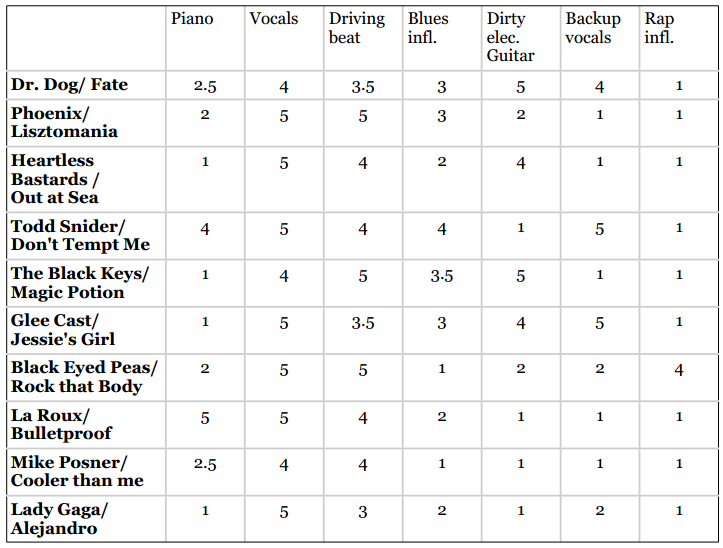

我们使用距离各种距离来推荐。

### 使用Python实现推荐逻辑
我们将上文中的歌曲特征数据用字典表示：

In [2]:
music = {
    "Dr Dog/Fate":{"piano": 2.5, "vocals": 4, "beat": 3.5, "blues": 3, "guitar": 5, "backup vocals": 4, "rap": 1},
    "Phoenix/Lisztomania": {"piano": 2, "vocals": 5, "beat": 5, "blues": 3, "guitar": 2, "backup vocals": 1, "rap": 1},
    "Heartless Bastards/Out at Sea": {"piano": 1, "vocals": 5, "beat": 4, "blues": 2, "guitar": 4, "backup vocals": 1, "rap": 1},
    "Todd Snider/Don't Tempt Me": {"piano": 4, "vocals": 5, "beat": 4, "blues": 4, "guitar": 1, "backup vocals": 5, "rap": 1},
    "The Black Keys/Magic Potion": {"piano": 1, "vocals": 4, "beat": 5, "blues": 3.5, "guitar": 5, "backup vocals": 1, "rap": 1},
    "Glee Cast/Jessie's Girl": {"piano": 1, "vocals": 5, "beat": 3.5, "blues": 3, "guitar":4, "backup vocals": 5, "rap": 1},
    "La Roux/Bulletproof": {"piano": 5, "vocals": 5, "beat": 4, "blues": 2, "guitar": 1, "backup vocals": 1, "rap": 1},
    "Mike Posner": {"piano": 2.5, "vocals": 4, "beat": 4, "blues": 1, "guitar": 1, "backup vocals": 1, "rap": 1},
    "Black Eyed Peas/Rock That Body": {"piano": 2, "vocals": 5, "beat": 5, "blues": 1, "guitar": 2, "backup vocals": 2, "rap": 4},
    "Lady Gaga/Alejandro": {"piano": 1, "vocals": 5, "beat": 3, "blues": 2, "guitar": 1, "backup vocals": 2, "rap": 1}
}

使用曼哈顿距离推荐：

In [3]:
def manhattan(rating1, rating2):
    distance = 0
    total = 0
    for key in rating1:
        if key in rating2:
            distance += abs(rating1[key] - rating2[key])
            total += 1
    return distance

def computeNearestNeighbor(username, users):
    distances = []
    for user in users:
        if user != username:
            distance = manhattan(users[user], users[username])
            distances.append((distance, user))
    # sort based on distance -- closest first
    distances.sort()
    return distances

computeNearestNeighbor('The Black Keys/Magic Potion', music)

[(4.5, 'Heartless Bastards/Out at Sea'),
 (5.5, 'Phoenix/Lisztomania'),
 (6.5, 'Dr Dog/Fate'),
 (8.0, "Glee Cast/Jessie's Girl"),
 (9.0, 'Mike Posner'),
 (9.5, 'Lady Gaga/Alejandro'),
 (11.5, 'Black Eyed Peas/Rock That Body'),
 (11.5, 'La Roux/Bulletproof'),
 (13.5, "Todd Snider/Don't Tempt Me")]

到底是什么特征影响了该推荐结果？我们可以比较两个特征向量：
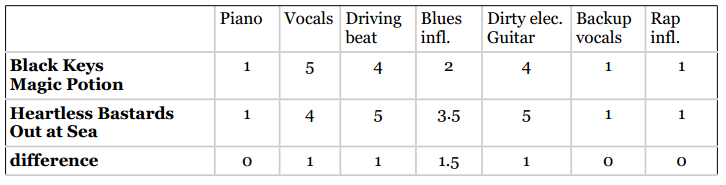

两首歌中最近的特征为piano、presence of backup vocals和rap influence，它们的差异都是0。但是这两首歌中这些特征的取值都处于最低端，它们都没有piano、presence of backup vocals和rap influence，如果我们说“因为这首歌没有backup vocals 所以才推荐”可能毫无作用。与此相反，我们应集中关注取值在高端的那些公共特征。

由于我们的数据集特征很少，均衡性也不好，因此其他的推荐结果并不像上面的推荐那样特别令人满意：

In [4]:
computeNearestNeighbor("Lady Gaga/Alejandro", music)

[(5, 'Heartless Bastards/Out at Sea'),
 (5.5, 'Mike Posner'),
 (6, 'La Roux/Bulletproof'),
 (6, 'Phoenix/Lisztomania'),
 (7.5, "Glee Cast/Jessie's Girl"),
 (8, 'Black Eyed Peas/Rock That Body'),
 (9, "Todd Snider/Don't Tempt Me"),
 (9.5, 'The Black Keys/Magic Potion'),
 (10.0, 'Dr Dog/Fate')]

Lady Gaga的这个推荐结果特别糟糕。

### 评分标准的问题
假如我想增加一种音乐特征——每分钟的鼓点数（bpm），用来判断这是一首快歌还是慢歌。以下是扩充后的数据集：
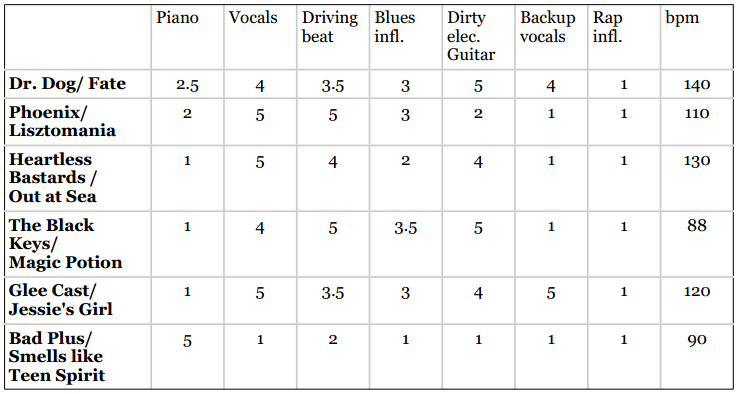

引入bpm后，bpm基本上就决定了两首歌的距离。

**事实上，评分标准不一是所有推荐系统的大敌！**

### 标准化
为了消除数据的偏斜性，我们必须要对数据标准化（standardization）或者说归一化（normalization）。一个常用的归一化方法会将每个特征的值转换为0到1之间。

关于均值、方差、标准差、标准分等内容参考统计学相关内容。
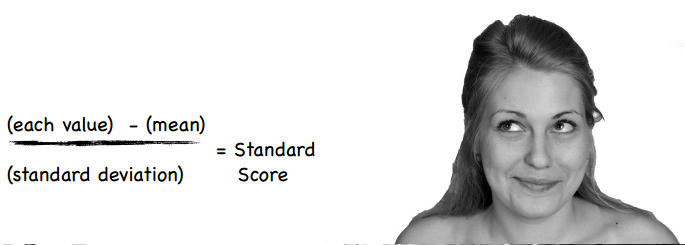

标准分容易受离群数据影响，所以我们可以用中位数计算绝对标准差来代替标准差：
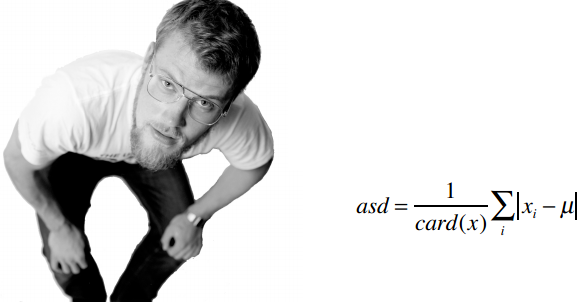

### 归一化 vs. 不归一化
在如下情况下应该进行归一化处理：
1. 所用数据挖掘方法基于特征的值来计算两个对象的距离
2. 不同特征的尺度不同（特别是有显著不同的情况，如上述例子中的询价和卧室数目）

### 一个完整的分类器
参考:
https://github.com/zealotcat/a_programmer_guide_to_data_mining